# Active Contours using Parameteric Curves

This tour explores image segmentation using parametric active contours.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

In [1]:
using PyPlot
using NtToolBox
# using Autoreload
# arequire("NtToolBox")

Parameteric Curves
-------------------

In this tours, the active contours are represented using parametric
curve $ \ga : [0,1] \rightarrow \RR^2 $. 


This curve is discretized using a piewise linear curve with 
$p$ segments, and is stored as a complex vector of points in the plane
$\ga \in \CC^p$.

Initial polygon.

In [2]:
gamma0 = [.78, .14, .42, .18, .32, .16, .75, .83, .57, .68, .46, .40, .72, .79, .91, .90] + 1im*[.87, .82, .75, .63, .34, .17, .08, .46, .50, .25, .27, .57, .73, .57, .75, .79];

Display the initial curve.

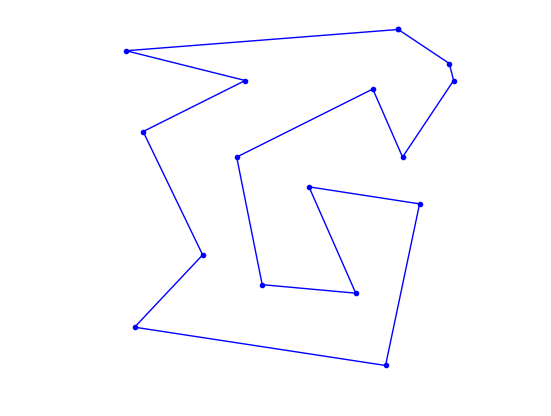

(0.1015,0.9485,0.040499999999999994,0.9095)

In [3]:
periodize = gamma -> [gamma; [gamma[1]]]
function cplot(gamma, s = "b", lw = 1) 
    plot(real(periodize(gamma)), imag(periodize(gamma)), s, linewidth = lw)
    axis("equal")
    axis("off")
end
cplot(gamma0, "b.-")

Number of points of the discrete curve.

In [4]:
p = 256;

Shortcut to re-sample a curve according to arc length.

In [5]:
using Dierckx
curvabs = gamma -> [0; cumsum(1e-5 .+ abs(gamma[1:end - 1] - gamma[2:end]) )]
resample11 = (gamma, d) -> evaluate(Spline1D(d./d[end], real(gamma), k=1), (0:p-1)./p)
resample12 = (gamma, d) -> evaluate(Spline1D(d./d[end], imag(gamma), k=1), (0:p-1)./p)
resample = gamma -> resample11( [gamma; gamma[1]], curvabs( [gamma; gamma[1]] ) ) + 1im*resample12( [gamma; gamma[1]], curvabs( [gamma; gamma[1]] ) );


LoadError: ArgumentError: Module Dierckx not found in current path.
Run `Pkg.add("Dierckx")` to install the Dierckx package.

Initial curve $ \ga_1(t)$.

In [6]:
gamma1 = resample(gamma0);

LoadError: UndefVarError: resample not defined

Display the initial curve.

In [7]:
cplot(gamma1, "k");

LoadError: UndefVarError: gamma1 not defined

Shortcut for forward and backward finite differences.

In [8]:
BwdDiff = c -> c - [c[end]; c[1:end - 1]]
FwdDiff = c -> [c[2:end]; c[1]] - c
dotp = (c1, c2) -> real(c1.*conj(c2));

The tangent to the curve is computed as
$$ t_\ga(s) = \frac{\ga'(t)}{\norm{\ga'(t)}} $$
and the normal is $ n_\ga(t) = t_\ga(t)^\bot. $

Shortcut to compute the tangent and the normal to a curve.

In [9]:
normalize = v -> v./max(abs(v), 1e-10)
tangent = gamma -> normalize( FwdDiff(gamma) )
normal = gamma -> -1im*tangent(gamma);

Move the curve in the normal direction, by computing $ \ga_1(t) \pm \delta n_{\ga_1}(t) $.

In [10]:
delta = .03
gamma2 = gamma1 .+ delta .* normal(gamma1)
gamma3 = gamma1 .- delta .* normal(gamma1);

LoadError: UndefVarError: gamma1 not defined

Display the curves.

In [11]:
cplot(gamma1, "k")
cplot(gamma2, "r--")
cplot(gamma3, "b--")
axis("tight") 
axis("off")

LoadError: UndefVarError: gamma1 not defined

## Evolution by Mean Curvature

A curve evolution is a series of curves $ s \mapsto \ga_s $ indexed by
an evolution parameter $s \geq 0$. The intial curve $\ga_0$ for
$s=0$ is evolved, usually by minizing some energy $E(\ga)$ in a gradient descent
$$ \frac{\partial \ga_s}{\partial s} = \nabla E(\ga_s). $$


Note that the gradient of an energy is defined with respect to the
curve-dependent inner product
$$ \dotp{a}{b} = \int_0^1 \dotp{a(t)}{b(t)} \norm{\ga'(t)} d t.  $$
The set of curves can thus be thought as being a Riemannian surface.


The simplest evolution is the mean curvature evolution.
It corresponds to minimization of the curve length
$$ E(\ga) = \int_0^1 \norm{\ga'(t)} d t $$


The gradient of the length is 
$$ \nabla E(\ga)(t) = -\kappa_\ga(t) n_\ga(t)  $$
where $ \kappa_\ga $ is the curvature, defined as
$$ \kappa_\ga(t) = \frac{1}{\norm{\ga'(t)}} \dotp{ t_\ga'(t) }{ n_\ga(t) } . $$



Shortcut for normal times curvature $ \kappa_\ga(t) n_\ga(t) $.

In [12]:
normalC = gamma -> BwdDiff(tangent(gamma)) ./ abs( FwdDiff(gamma) );

Time step for the evolution.
It should be very small because we use an explicit time stepping and the
curve has strong curvature.

In [13]:
dt = 0.001 / 100;

Number of iterations.

In [14]:
Tmax = 3.0 / 100
niter = round(Tmax/dt);

Initialize the curve for $s=0$.

In [15]:
gamma = gamma1;

LoadError: UndefVarError: gamma1 not defined

Evolution of the curve.

In [16]:
gamma = gamma .+ dt .* normalC(gamma);

LoadError: MethodError: no method matching endof(::Base.Math.#gamma)[0m
Closest candidates are:
  endof([1m[31m::SimpleVector[0m) at essentials.jl:169
  endof([1m[31m::Char[0m) at char.jl:18
  endof([1m[31m::String[0m) at strings/string.jl:37
  ...[0m

To stabilize the evolution, it is important to re-sample the curve so
that it is unit-speed parametrized. You do not need to do it every time
step though (to speed up).

In [17]:
gamma = resample(gamma);

LoadError: UndefVarError: resample not defined

**Exercise 1:** Perform the curve evolution.
You need to resample it a few times.

In [18]:
include("NtSolutions/segmentation_2_snakes_param/exo1.jl")

LoadError: LoadError: UndefVarError: gamma1 not defined
while loading /Users/gpeyre/Dropbox/github/numerical-tours/julia/NtSolutions/segmentation_2_snakes_param/exo1.jl, in expression starting on line 1

## Geodesic Active Contours

Geodesic active contours minimize a weighted length
$$ E(\ga) = \int_0^1 W(\ga(t)) \norm{\ga'(t)} d t, $$
where $W(x)>0$ is the geodesic metric, that should be small in areas
where the image should be segmented.

Size of the image $n$.

In [19]:
n = 200;

Create a synthetic weight $W(x)$.

In [20]:
nbumps = 40
theta = rand(nbumps,1).*(2*pi)
r = .6*n/2
a = [.62*n,.6*n]
x = round( a[1] + r*cos(theta) )
y = round( a[2] + r*sin(theta) )
W = zeros(n, n)
for i in 1:nbumps
    W[Int(x[i]), Int(y[i])] = 1
end
W = gaussian_blur(W, 6.0)
W = rescale( -min(W, .05), .3,1);

Display the metric $W$.

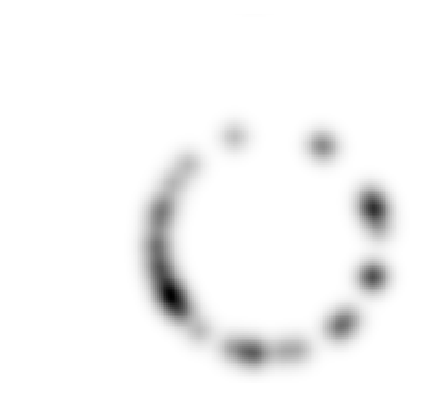

In [21]:
imageplot(W)

Pre-compute the gradient $\nabla W(x)$ of the metric.

In [22]:
G = grad(W)
G = G[:,:,1] .+ 1im*G[:, :, 2];

Display the image of the magnitude $\norm{\nabla W(x)}$ of the gradient.

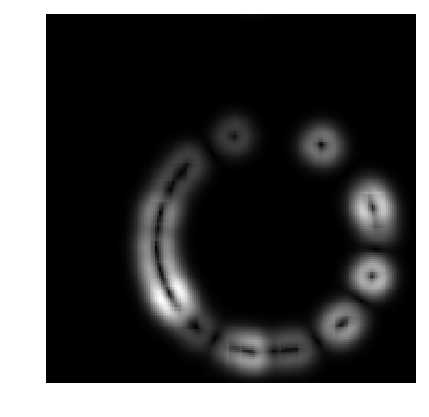

In [23]:
imageplot(abs(G))

Shortcut to evaluate the gradient and the potential along a curve.

In [24]:
EvalG = gamma -> NtToolBox.bilinear_interpolate(G, imag(gamma), real(gamma))
EvalW = gamma -> NtToolBox.bilinear_interpolate(W, imag(gamma), real(gamma));

Create a circular curve $\ga_0$.

In [25]:
r = .98*n/2 # radius
p = 128 # number of points on the curve
theta = transpose( linspace(0, 2*pi, p + 1) )
theta = theta[1 : end - 1]
gamma0 = n/2 * (1 + 1im) +  r*(cos(theta) + 1im*sin(theta));

Initialize the curve at time $t=0$ with a circle.

In [26]:
gamma = gamma0;

For this experiment, the time step should be larger, because the
curve is in $[0,n-1] \times [0,n-1]$.

In [27]:
dt = 1;

Number of iterations.

In [28]:
Tmax = 5000
niter = round(Tmax/ dt);

Display the curve on the background.

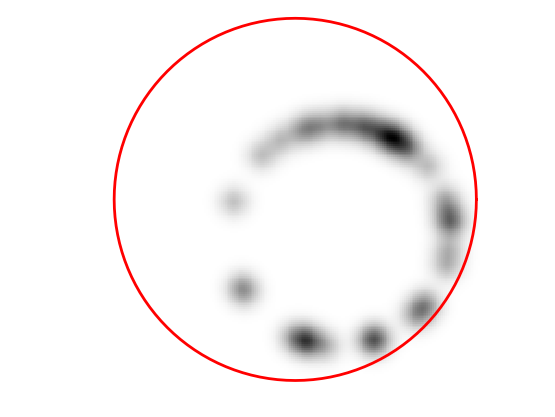

(-0.5,199.5,199.5,-0.5)

In [29]:
lw = 2
clf
imageplot(transpose(W))
cplot(gamma, "r", lw)

The gradient of the energy is
$$ \nabla E(\ga) = -W(\ga(t)) \kappa_\ga(t) n_\ga(t) + \dotp{\nabla W(\ga(t))}{ n_\ga(t) } n_\ga(t). $$

Pointwise innerproduct on the curve.

In [30]:
dotp = (c1,c2) -> real(c1.*conj(c2));

Evolution of the curve according to this gradient.

In [31]:
N = normal(gamma)
g = - EvalW(gamma) .* normalC(gamma) + dotp(EvalG(gamma), N) .* N
gamma = (gamma - dt*g);

LoadError: MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Int64
This may have arisen from a call to the constructor Int64(...),
since type constructors fall back to convert methods.

To avoid the curve from being poorly sampled, it is important to
re-sample it evenly.

In [32]:
gamma = resample(gamma);

LoadError: UndefVarError: resample not defined

**Exercise 2:** Perform the curve evolution.

In [33]:
include("NtSolutions/segmentation_2_snakes_param/exo2.jl")


# gamma = copy(gamma0);
# displist = round(linspace(0, niter, 10))
# k = 1;
# clf; 
# imageplot(transpose(W));
# track  = gamma
# for i in 0 : niter
#     N = normal(gamma);
#     g = EvalW(gamma) .* normalC(gamma) - dotp(EvalG(gamma), N) .* N;
#     gamma = resample( (gamma + dt*g)); 
#     if i == displist[k]   
#         lw = 1
#         if (i == 0) | (i == niter)
#             lw = 4
#         end
#         cplot(gamma, "r", lw);
#         k = k + 1;
#         axis("equal"); axis("off");
#     end
# end

LoadError: LoadError: MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Int64
This may have arisen from a call to the constructor Int64(...),
since type constructors fall back to convert methods.
while loading /Users/gpeyre/Dropbox/github/numerical-tours/julia/NtSolutions/segmentation_2_snakes_param/exo2.jl, in expression starting on line 7

# Medical Image Segmentation

One can use a gradient-based metric to perform edge detection in medical
images.

Load an image $f$.

In [34]:
n = 256
name = "NtToolBox/src/data/cortex.png"
f = load_image(name, n);

Display.

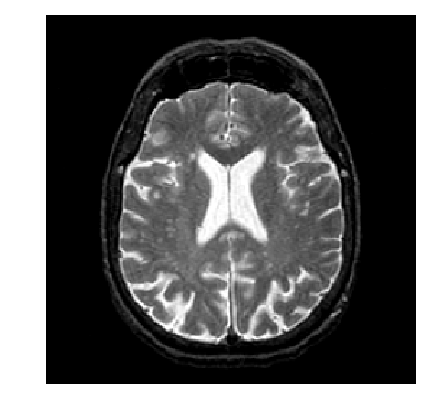

In [35]:
imageplot(f)

An edge detector metric can be defined as a decreasing function of the
gradient magnitude.
$$ W(x) = \psi( d \star h_a(x) )
      \qwhereq d(x) = \norm{\nabla f(x)}. $$
where $h_a$ is a blurring kernel of width $a>0$.

Compute the magnitude of the gradient.

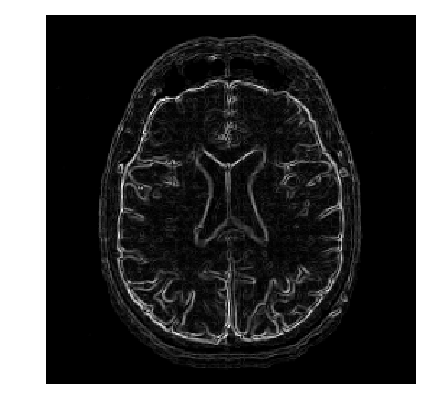

In [36]:
G = grad(f)
d0 = sqrt(sum(G.^2, 3))
imageplot(d0[:, :, 1])

Blur it by $h_a$.

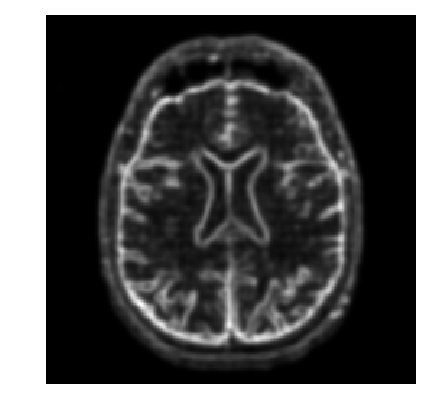

In [37]:
a = 2
d = gaussian_blur(d0, a)
imageplot(d[:, :, 1])

In [38]:

f = copy(d0)

n = maximum(size(f))
# t = [collect(0:n/2); collect(-n/2:-2)]
# (Y, X) = meshgrid(t, t)
# h = exp( -(X.^2 + Y.^2)./(2.0*float(sigma)^2) )
# h = h./sum(h)
# real(plan_ifft((plan_fft(f)*f).*(plan_fft(h)*h))*((plan_fft(f)*f).*(plan_fft(h)*h)))


256

Compute a decreasing function of the gradient to define $W$.

In [39]:
d = min(d, .4)
W = rescale(-d, .8, 1);

Display it.

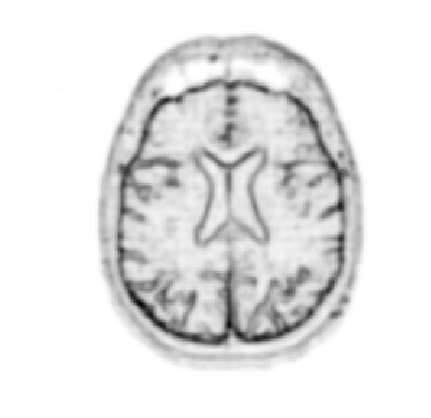

In [40]:
imageplot(W[:, :, 1])

Number of points.

In [41]:
p = 128;

**Exercise 3:** Create an initial circle $\gamma_0$ of $p$ points. When plotting the image, you need to transpose it to have axis coherent with the cplot.

In [42]:
include("NtSolutions/segmentation_2_snakes_param/exo3.jl")

LoadError: LoadError: transpose not implemented for Array{Float32,3}. Consider adding parentheses, e.g. A*(B*C.') instead of A*B*C' to avoid explicit calculation of the transposed matrix.
while loading /Users/gpeyre/Dropbox/github/numerical-tours/julia/NtSolutions/segmentation_2_snakes_param/exo3.jl, in expression starting on line 8

Step size.

In [43]:
dt = 2;

Number of iterations.

In [44]:
Tmax = 9000
niter = round(Tmax/ dt);

**Exercise 4:** Perform the curve evolution.

In [45]:
include("NtSolutions/segmentation_2_snakes_param/exo4.jl")

# G = grad(W);
# G = G[:, :, 1] + 1im*G[:, :, 2]
# EvalG = gamma -> NtToolBox.bilinear_interpolate(G, imag(gamma), real(gamma))
# EvalW = gamma -> NtToolBox.bilinear_interpolate(W, imag(gamma), real(gamma))
# #
# gamma = gamma0
# displist = round(linspace(0, niter, 10))
# k = 1;
# clf
# imageplot(transpose(f))
# for i in 0 : niter - 1
#     n = normal(gamma)
#     g = EvalW(gamma) .* normalC(gamma) - dotp(EvalG(gamma), n) .* n
#     gamma = resample( gamma + dt*g )
#     if i == displist[k]  
#         lw = 1;    
#         if (i == 0) | (i == niter)
#             lw = 4;
#         end
#         cplot(gamma, "r", lw);
#         k = k + 1;
#         axis("equal"); axis("off");
#     end
# end



LoadError: LoadError: transpose not implemented for Array{Float32,3}. Consider adding parentheses, e.g. A*(B*C.') instead of A*B*C' to avoid explicit calculation of the transposed matrix.
while loading /Users/gpeyre/Dropbox/github/numerical-tours/julia/NtSolutions/segmentation_2_snakes_param/exo4.jl, in expression starting on line 10

# Evolution of a Non-closed Curve

It is possible to perform the evolution of a non-closed curve by adding
boundary constraint
$$ \ga(0)=x_0 \qandq \ga(1)=x_1. $$


In this case, the algorithm find a local minimizer of the geodesic
distance between the two points.


Note that a much more efficient way to solve this problem is to use the
Fast Marching algorithm to find the global minimizer of the geodesic
length.


Load an image $f$.

In [46]:
n = 256
f = load_image(name, n)
f = f[45:105, 60:120]
n = size(f)[1];

Display.

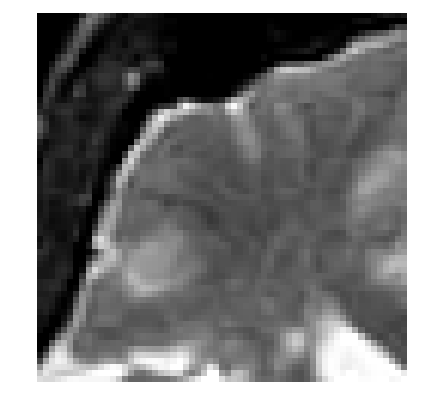

In [47]:
imageplot(f)

**Exercise 5:** Compute an edge attracting criterion $W(x)>0$, that is small in area of strong
gradient.

In [48]:
include("NtSolutions/segmentation_2_snakes_param/exo5.jl")

LoadError: LoadError: UndefVarError: ff not defined
while loading /Users/gpeyre/Dropbox/github/numerical-tours/julia/NtSolutions/segmentation_2_snakes_param/exo5.jl, in expression starting on line 1

Start and end points $x_0$ and $x_1$.

In [49]:
x0 = 4 + 55*1im
x1 = 53 + 4*1im;

Initial curve $\ga_0$.

In [50]:
p = 128
t = transpose(linspace(0, 1, p))
gamma0 = t*x1 + (1 - t)*x0;

Initialize the evolution.

In [51]:
gamma = gamma0;

Display.

In [52]:
clf
imageplot(transpose(W))
cplot(gamma[:],"r", 2)
plot(real(gamma[1]), imag(gamma[1]), "b.", markersize = 20)
plot(real(gamma[end]), imag(gamma[end]), "b.", markersize = 20);

LoadError: transpose not implemented for Array{Float64,3}. Consider adding parentheses, e.g. A*(B*C.') instead of A*B*C' to avoid explicit calculation of the transposed matrix.

Re-sampling for non-periodic curves.

In [53]:
using Dierckx
curvabs = gamma -> [0; cumsum(1e-5 .+ abs(gamma[1 : end - 1] - gamma[2 : end]) )]
resample11 = (gamma, d) -> evaluate(Spline1D(d./d[end], real(gamma), k=1), (0:p-1)./p)
resample12 = (gamma, d) -> evaluate(Spline1D(d./d[end], imag(gamma), k=1), (0:p-1)./p)
resample = gamma -> resample11( [gamma; gamma[1]], curvabs( [gamma; gamma[1]] ) ) + 1im*resample12( [gamma; gamma[1]], curvabs( [gamma; gamma[1]] ) )

LoadError: ArgumentError: Module Dierckx not found in current path.
Run `Pkg.add("Dierckx")` to install the Dierckx package.

Time step.

In [54]:
dt = 1/10;

Number of iterations.

In [55]:
Tmax = 2000*4/ 7
niter = round(Tmax/ dt);

**Exercise 6:** Perform the curve evolution.
Be careful to impose the boundary conditions at each step.

In [56]:
include("NtSolutions/segmentation_2_snakes_param/exo6.jl")


# G = grad(W);
# G = G[:, :, 1] + 1im*G[:, :, 2]
# EvalG = gamma -> NtToolBox.bilinear_interpolate(G, imag(gamma), real(gamma))
# EvalW = gamma -> NtToolBox.bilinear_interpolate(W, imag(gamma), real(gamma))
# #
# gamma = gamma0[:];
# displist = round(linspace(0, niter, 10))
# k = 1;
# clf
# imageplot(transpose(f))
# for i in 0 : niter
#     N = normal(gamma)
#     g = EvalW(gamma) .* normalC(gamma) - dotp(EvalG(gamma), N) .* N
#     gamma = gamma + dt*g
#     gamma = resample( gamma )
#     # impose start/end point
#     gamma[1] = x0
#     gamma[end] = x1
#     if i == displist[k]   
#         lw = 1;    
#         if (i == 0) | (i == niter)
#             lw = 4;
#         end
#         cplot(gamma, "r", lw);
#         k = k + 1;
#         axis("equal"); axis("off");
#         plot(real(gamma[1]), imag(gamma[1]), "b.", markersize = 20)
#         plot(real(gamma[end]), imag(gamma[end]), "b.", markersize = 20);
#     end
# end

LoadError: LoadError: MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Int64
This may have arisen from a call to the constructor Int64(...),
since type constructors fall back to convert methods.
while loading /Users/gpeyre/Dropbox/github/numerical-tours/julia/NtSolutions/segmentation_2_snakes_param/exo6.jl, in expression starting on line 11